### ECE/CS/ISyE 524 &mdash; Introduction to Optimization ###

# Sentiment Adjusted Trading Optimization #

#### Will Geister (wgeister@wisc.edu), Timothy Pavelko (email address), Shing Shen (email address)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Data Collection](#2-data-collection)
    
      1. [Data Collection/Stock API + Historical Stock Data](#2a-stock-api--historical-stock-data)
      1. [Data Collection/Twitter API](#2b-twitter-api) <---- Timothy click here for your section
1. [Mathematical Model](#3.-Mathematical-model)

    1. [Mathematical Model/Non-Sentiment Adjusted](#3a-non-sentiment-adjusted)
    1. [Mathematical Model/Sentiment Adjusted](#3b-sentiment-adjusted)
1. [Implementation](#4.-Implementation)
    
    1. [Implementation/Imports](#4a.-Imports)
    1. [Implementation/Returns Calculated](#4b.-Returns-Calculated)
    1. [Implementation/Non Sentiment Portion](#4c.-NON-SENTIMENT-PORTION)
    1. [Implementation/Sentiment Portion](#4d-SENTIMENT-PORTION)
1. [Results and Discussion](#5.-Results-and-discussion)
      
      1. [Results and Discussion/Without Sentiment Prediction](#5a.-Without-Sentiment-Prediction)
      1. [Results and Discussion/With Sentiment Prediction](#5b.-With-Sentiment-Prediction)
1. [Conclusion](#6.-Conclusion)

    1. [Conclusion/Case Study](#6a.-Case-Study)

## 1. Introduction ##

With the virtually infinite amount of information floating around on social media about current world affairs, it would be nice to be able to automatically parse the information and get the data you need related to which investments you should buy. We can solve this problem by building a program to automatically scrape the data and derive key details from it using AI. 

#### Economic part
Economic component focuses on traditional financial metrics. We can estimate baseline returns using publicly available and historical data. The risk assessment includes the covariance matrix estimation with appropriate constraints.

#### Political part
This part involves analyzing high ranking or highly influential political figures. The LLM will be able to match a figure and what they are saying to a relevant industry or company. This is the main information source that will influence the sentiment score which will tell us what we should buy and what we should stay away from

#### Fusion of the parts
Sentiment scores will adjust baseline expected returns for each asset. Recent tweets will receive higher weights than older ones. The model will dynamically adjust the importance of political sentiment based on historical predictive success. Regular recalibration will ensure the model adapts to changing market conditions.

#### Analysis
We will measure our sentiment predictive power through tests after a period of time has passed to see how well our model performed. We will also attempt to measure which people/individuals have the strongest market impact.

#### Data requirements
 - Access to tweets via the twitter API
 - Access to financial APIs with relevant and up to date information such as daily stock prices and return data
 - Access to a powerful enough LLM

## 2. Data Collection ##

Our data needed to come from a few different sources, historical stock data, current up to date stock data, and X tweets. These all required different vectors of data collection and pre-processing before being used by our optimization model (Included in the .ipynb). Please note that demonstrations of the code are available below, that being said, all python files are not gone over here as they are relatively unimportant to the grand project, but are available in the repository [here](https://github.com/TimothyPav/sentiment-predict).

## 2a. Stock API + Historical Stock Data ##
Our stock data can be broadly broken down into 2 different categories:

- Daily Stock Data
- Historical Stock Data

This project initially started off by using Daily stock data entirely, but this did not provide enough variance to collect adequate stock data so we had to add historic data. We build out our data matrix by giving a bias of 1:1 daily:historical data, building out a matrix that takes both the volatile nature of todays markets and a matrix that has enough stock variance to make some sort of long term predictions

#### Stock Data Collection Historical

Historical stock data can be easily gotten from [kaggle/stock_data](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset?resource=download) and extracted from our sample number of stocks using the python code below:

```python
for ticker in tickers_df['tickers']:
        ticker = ticker.upper()
        filename = f"{ticker}.csv"

        if not os.path.isfile(filename):
            print(f"Warning: File {filename} does not exist. Skipping.")
            continue

        # Read the individual ticker CSV
        df = pd.read_csv(filename)

        # Select and rename the columns
        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
        df.rename(columns={
            'Date': 'timestamp',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }, inplace=True)

        # Add the ticker column
        df['ticker'] = ticker

        # Format timestamp to add '00:00:00'
        df['timestamp'] = df['timestamp'] + ' 00:00:00'

        # Reorder columns
        df = df[['ticker', 'timestamp', 'open', 'high', 'low', 'close', 'volume']]

        master_data.append(df)
```
This then can be fed into a variety of data cleaners, clippers, and modifiers to make the data interface with our combiner later.
#### Stock Data Collection Daily

Large detailed stock datasets were hard to come by, so we had to come up with a strategy to build a large enough dataset within a few acceptance criteria:

- A large array of stocks, given in this project as "stock_tickers.csv" or S
- Stocks that were going to stay relatively stable, for this I selected a list of the companies with the largest market cap descending, and collected as large a data set as possible $(\max(size(S)))$
- Stocks that were freely available with the data from Alpha Vantage (the API used in this project) set of Alpha Vantage given $A$, condition $S \in A$
- Stocks will be picked from the top of the Nasdaq top stock list $S_i = N_i, i = {1,2,3,\dots,n}$
- Number of pulls the API will allow me to do from Wall Street close on Friday to open on Monday (don't know how to express this one as the API throttling seems to happen at random)

Provided mathematically as:

$$\max(size(S))$$

$$s.t.$$

$$S \in A$$

$$S_i = N_i, i = \{ 1,2,3,\dots,n \}$$

n = the number of entries I am able to pull during the weekend the NYSE is closed

#### $$S_i = N_i, i = \{ 1,2,3,\dots,n \}$$
This was a very simple constraint to follow because it just required me to search the NASDAQ for the highest market cap companies and download the 6000 entry long csv of stock valuation and tickers, that I can isolate the tickers on ([nasdq.com/highest market cap](https://www.nasdaq.com/market-activity/index/spx/historical?page=1&rows_per_page=10&timeline=m1)). This data could not be directly used as the stock market is in a state of flux which necessitates a higher amount of granularity see constraint below.

#### $$S \in A$$
This project relies upon the stock data that can be freely procured from the Alpha Vantage API ([alphavantage.co/documentation](https://www.alphavantage.co/documentation/)), this constraint wa probed by using the above constraint set, using error handling for checking if it wasn't in the set (after an 8 hour timeout, that was found to be enough for the API timeout to reset) :

```python
max_retries = 5

...

if not time_series:
            print(f"No time series data found for {symbol}.") #bad data catch
            return
```

#### $$\max(size(S))$$
This function is more served as me running a few scripts periodically throughout the weekend to maximize the number of stocks that can be grabbed from the API. It is run wit this .bat file:

```bat
@echo off

echo Starting up the app...

python -m compileall -q .

python main.py

pause
```
But the pertinent code for this report and this class is this:
```python
for attempt in range(max_retries):
            for i, key in enumerate(keys):
                url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=30min&apikey={key}' ## url to alphavantage
                response = requests.get(url)
                data = response.json()

                if "Meta Data" in data and "Time Series (30min)" in data:
                    print(f"[Key {i + 1}] Success for {symbol}.")
                    break
                else:
                    print(f"[Key {i + 1}] failed or rate-limited. Trying next key...") ## catch if they are limiting my rates (although I am starting to think it is by static ip)

            else:
                print(f"[Attempt {attempt + 1}] All keys failed. Waiting {retry_delay / 60} minutes...")
                if attempt == 3: # ratchet catch to get all the data I could glean so far, will overwrite if I get more data
                    downloader = stockCSVDownloader()
                    downloader.move_to_downloads("stocks.csv") #actual downloader

                    printer = lastStockPrinter()
                    printer.move_last_stock_to_downloads(symbol, str(self.count))
                    continue
                elif attempt == 4:
                    time.sleep(retry_delay * 8) #long sleeper so I can afk this

                time.sleep(retry_delay)
                continue
            break
        else:
            print(f"Failed to fetch data for {symbol} after {max_retries} retries.")
            return
```
This peice of code queries the API and adds the stock data to the csv that will be staged and downloaded after 3 failed attempts (my "soft catch" that hopefully catches when the API starts to throttle me.) after it throttles me, it prints out the last stock to be queried, I turn on a vpn, and continue the process from the last stock ticker it printed out.

All stocks_# are then combined and fed into a variance calculator made in Julia, given below:

```python
using CSV
using DataFrames
using Statistics

df = CSV.read("top_stocks_data.csv", DataFrame)
grouped = groupby(df, :ticker)

results = DataFrame(
    ticker = String[],
    open_variance = Float64[],
    high_variance = Float64[],
    low_variance = Float64[],
    close_variance = Float64[],
    volume_variance = Float64[],
)

for g in grouped
    push!(results, (
        ticker = first(g.ticker),
        open_variance = var(g.open),
        high_variance = var(g.high),
        low_variance = var(g.low),
        close_variance = var(g.close),
        volume_variance = var(g.volume),
    ))
end

CSV.write("stock_variance.csv", results)

println("Variance data was written to stock_variance.csv.")
```
#### Combining the stock data

Because these data sheets (.csv) are theoretically formatted correctly, I combined the via google sheets and uploaded them to then be optimized via our optimizer written in Julia to get the best stocks according to just stock calculation, non-considering the twitter sentiment that will effect the final verdict.



## 2b. Twitter API ##

#### TIMOTHY PLEASE PUT DOCUMENTATION HERE

## 3. Mathematical model ##

Before getting into each model, we should go over the overarching goal: we aim to optimize a stock portfolio by balancing expected returns and risk. Both of our models follow a classic mean-variance optimization framework. This involves selecting stock allocations that maximize expected return while penalizing portfolio risk, represented through variance. The key difference between the two lies in how expected returns are calculated: the first model uses stock data only, while the second incorporates sentiment analysis to adjust those expectations. Each model also applies a diversification constraint to prevent over-concentration in any single asset.

## 3a. Non Sentiment Adjusted ##
$$
\begin{aligned}
\underset{x \in \mathbb{R}^n}{\text{maximize}}\quad & \mathbf{E}^T x \\
\text{subject to:} \quad & \sum_{i=1}^{n} x_i = 1, \\
& x_i \leq \frac{\eta}{100} \quad \text{for all} \quad i = 1, \dots, n, \\
& x_i \leq \kappa \quad \text{for all} \quad i = 1, \dots, n, \\
& x_i \geq 0 \quad \text{for all} \quad i = 1, \dots, n
\end{aligned}
$$
Where:
  - $x_i$ represents the allocation to the $i$-th stock in the portfolio.
  - $\mathbf{E}$ is the vector of expected returns for each stock, i.e., $\mu_{NS}$ from the code.
  - Where $\kappa$ is the maximum allocation for any stock, this is to try to get some diversity in our trades
  - The objective function is to maximize the expected return of the portfolio, $\mathbf{E}^T x$, which is the dot product of the expected return vector and the allocation vector.
  - The first constraint ensures that the sum of the allocations is 1, meaning the portfolio is fully invested.
  - The second constraint limits the maximum allocation to any single stock to a percentage parameter given here as $\eta$ this is to make our optimizer be forced to diversify rather than just dumping everything into a high return stock
  - The third constraint ensures that the allocations are non-negative

Additionally, the code incorporates a risk term related to the portfolio's variance or covariance matrix $\sigma$, where the risk is penalized in the objective function. This can be incorporated as follows:
$$
\text{Objective:} \quad \mathbf{E}^T x - \lambda x^T \sigma x \\
$$


Where:
  - $\sigma$ is the covariance matrix of stock returns.
  - $\lambda$ is the risk aversion parameter (set to 0.5 in the code). The term $\lambda x^T \sigma x$ penalizes the variance of the portfolio, thus balancing between maximizing return and minimizing risk.

## 3b. Sentiment Adjusted ##

However this all constitutes how a normal trade optimizer works, our "sentiment-adjusted" trade optimizer adds a new variable into the mix

$$
\begin{aligned}
\underset{x \in \mathbb{R}^n}{\text{maximize}}\quad & \mathbf{E}^T_{SA} x \\
\text{subject to:} \quad & \sum_{i=1}^{n} x_i = 1, \\
& x_i \leq \frac{\eta}{100} \quad \text{for all} \quad i = 1, \dots, n, \\
& x_i \leq \kappa \quad \text{for all} \quad i = 1, \dots, n, \\
& x_i \geq 0 \quad \text{for all} \quad i = 1, \dots, n
\end{aligned}
$$
Where:
  - all elements are the same as the past except:
  - $\mathbf{E}_{SA}$ is the vector of expected returns for each stock, The $SA$ portion of the $\mathbf{E}_{SA}$ estimated returns that are calculated using the sentiment predictors i.e., $\mu_{SA}$ from the code.
  - The objective function is to maximize the expected return of the portfolio, while taking into mind the sentiment predictors from the code $\mathbf{E}^T_{SA} x$, which is the dot product of the expected return vector and the allocation vector.

This function still works off of the risk adjusted formula given below as:
$$
\text{Objective:} \quad \mathbf{E}^T_{SA} x - \lambda x^T \sigma x \\
$$

#### Matrix Operations

In the provided optimization models as above, the matrices and vectors may not be explained in enough detail to understand our code portion Matrices are only used on the objective function. A brief explanation for each is provided:

**Matrices are below**

- $\mu$ - `muS` or `muNS` in the code is a vector of expected returns, or in the math above represented by $\mathbf{E}$ (or $\mathbf{E}_{SA}$). It is a $1 \times n$ matrix where $n$ is the number of stocks sampled

- $\sigma$ - or `Sigma` in the code is a covariance matrix of stock returns it is a $n \times n$ matrix where each element $\sigma_ij$ represents the covariance between stock $i$ and stock $j$.

- $x$ - or `x` in the code is a vector of allocation weights to be optimized, where each element $x_i$ represents the weight assigned to the $i$th stock in the portfolio.

**Operations are below:**

- Expected Return Term: $\mu^T \cdot x$ 
  * Shape: $(1, n) \cdot (n)$ gives a scalar  
  * This is the dot product of the expected returns and the allocation vector.

- Risk Term: $x^T \cdot \sigma \cdot x$  
  * Shape: $(1, n) \cdot (n, n) \cdot (n)$ gives a scalar 
  * This computes the quadratic form to represent portfolio variance.

## 4. Implementation ##

As you can probably tell by our project design, we will have two different parts of code, one that calculates stock returns as normal and another that calculates them as a function of the sentiment expressed by certain "high influence" figures' twitter activity. The first two code boxes establish a common stock data set that will be used in the calculations to make the two different predictions in the third and fourth code boxes.


#### SENTIMENT AND NON SENTIMENT PORTION
As you are probably able to tell, this first part runs all of the packages we will use and loads the csv data into a dataframe. We need to calculate the approximate daily return using the formula: $$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$
where:
- $r_t$ is the return at time t
- $P_t$ is the price at time t

## 4a. Imports ##

In [1]:
using CSV
using DataFrames
using Statistics
using JuMP
using Ipopt
using Plots
using StatsBase

# Load stock data
stock_data = CSV.read("./final_data/master_stock_data_sectors.csv", DataFrame)

# Load constructor csv
ticker_sector = CSV.read("./final_data/tickers_with_sectors.csv", DataFrame)
sector_sentiment = CSV.read("./final_data/sector_sentiment.csv", DataFrame)

# lookup dictionaries
ticker_to_sector = Dict(row.ticker => row.sector for row in eachrow(ticker_sector))
sector_to_sentiment = Dict(row.Sector => row.Average_Sentiment_Score for row in eachrow(sector_sentiment))

function compute_returns(df)
    df = sort(df, :ticker)
    returns = [missing; diff(df.close) ./ df.close[1:end-1]]
    df[!, :return] = returns
    return df
end

returns_data = combine(groupby(stock_data, :ticker), compute_returns) # Compute returns
returns_wide = unstack(returns_data, :ticker, :return; combine=mean)
returns_wide_clean = dropmissing(returns_wide) # Drop rows with missing returns

println("Data Read IN")

Data Read IN


## 4b. Returns Calculated ##

This is where the first math is done, where the returns are calculated based on the data and stored in `sigma`, this is the final part of code that both the sides of non-sentiment adjustment and the sentiment adjustment side converge.

When we have calculated the returns, we can compute the covariance matrix $\Sigma$ this is a square matrix that describes the covariances between different stocks in the portfolio. This matrix can be given by $$\sigma_{ij} = \text{Cov}(r_i, r_j) = \frac{1}{N-1} \sum_{t=1}^{N} (r_{i,t} - \bar{r}_i)(r_{j,t} - \bar{r}_j)$$ Where: $\sigma_{ij} \in \Sigma = $ `sigma`

In [2]:
clean_stocks = names(returns_wide_clean) # Stocks that have all data
valid_stock_data = filter(row -> row[:ticker] in clean_stocks, stock_data)
returns_matrix = Matrix{Float64}(returns_wide_clean[:, clean_stocks])

sigma = cov(returns_matrix) # Compute the covariance matrix for the returns (sigma)
println("Sigma calculated")

Sigma calculated


This is a user defined diversification parameter that will limit both analysis' ability to just invest everything in the top performing stock

In [3]:
# user-defined top threshold for how much can be invested into each stock a "diversification" parameter
max_allocation = .07  # ADJUST HERE
println("Sentiment weight saved")

Sentiment weight saved


## 4c. NON SENTIMENT PORTION ##

This first chunk of code is our start of our non-sentiment adjusted stock predictor.

The expected return (given in the vector $\mu$) is the difference between the open and close which yeilds:$$\mu_i = \frac{1}{T} \sum_{t=1}^{T} \frac{P_{i,\text{open},t} - P_{i,\text{close},t}}{P_{i,\text{open},t}}$$

In [4]:
muNS = Float64[]

for stock in clean_stocks
    timepoints = subset(valid_stock_data, :ticker => ByRow(==(stock)))

    # Compute return for each row, filtering out bad data
    returns = [(row[:open] - row[:close]) / row[:open] for row in eachrow(timepoints)
               if !ismissing(row[:open]) && !ismissing(row[:close]) && row[:open] != 0.0]

    # Skip stock if no valid returns
    if isempty(returns)
        continue
    end

    expected_return = mean(returns)

    # Skip stock if return is invalid
    if isnan(expected_return) || isinf(expected_return)
        continue
    end

    push!(muNS, expected_return)
end
println("muNS calculated")


muNS calculated


This part of the code fills in elements in the code where there may have been gaps from the pull by extrapolating data from other relevant cells.

Then it runs the optimizer (Optimizer: Quadratic), where the objective is $\min(\text{risk})$ while getting a certian expected return, this function can be represented as: $$\text{Objective} = - \mu^T x + \lambda x^T \Sigma x$$

In [5]:
extra_elements_needed = size(sigma, 1) - length(muNS)
if extra_elements_needed > 0 # If extra elements are needed, add duplicate entries to mu, manually fix data later
    push!(muNS, repeat([muNS[end]], extra_elements_needed)...)
end

lambda = 0.5
model = Model(Ipopt.Optimizer)
n_stocks = length(muNS)

@variable(model, x[1:n_stocks] >= 0)
@constraint(model, sum(x) == 1)

@constraint(model, [i=1:n_stocks], x[i] <= max_allocation)  # Limit: max 30% allocation per stock given in the math portion as eta

@objective(model, Min, -muNS' * x + lambda * (x' * sigma * x))

set_optimizer_attribute(model, "print_level", 0)  # silence IPopt

optimize!(model)

println("Optimized")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Optimized


This part is basically for clipping off bad data and making it ready for a csv export

In [6]:
stocks_info = [(clean_stocks[i], value(x[i]), muNS[i]) for i in 1:n_stocks]

# Sort stocks by optimal allocation (descending) for risk categorization
sorted_stocks = sort(stocks_info, by = x -> x[2], rev=true)

# List of tickers to drop <-- this is needed because of empty data slots from our api calls and a generative function that assigns them for unused matrix slots
tickers_to_drop = Set(["open", "close", "high", "low", "volume", "sector", "CCZ"])
filtered_stocks = filter(stock_info -> !(stock_info[1] in tickers_to_drop), sorted_stocks)

# Add sector information to each stock to better understand the sentiment
stocks_with_sectors = [
    (stock[1], stock[2], stock[3], get(ticker_to_sector, stock[1], "Unknown")) 
    for stock in filtered_stocks
]

csv_filename = "./final_data/top_stocks_no_sentiment.csv"
CSV.write(csv_filename, DataFrame(
    Stock = [stock[1] for stock in stocks_with_sectors],
    Allocation = [stock[2] * 100 for stock in stocks_with_sectors],
    ExpectedReturn = [stock[3] * 100 for stock in stocks_with_sectors],
    Sector = [stock[4] for stock in stocks_with_sectors]
))

println("Results saved to $csv_filename.")

Results saved to ./final_data/top_stocks_no_sentiment.csv.


## 4d. SENTIMENT PORTION ##

This is our sentiment adjusted portion, below is how heavily the sentiment weight will weigh on the final call on what stocks to buy:

In [7]:
# user-defined weight for sentiment influence
sentiment_weight = 10.0  # ADJUST HERE
println("Sentiment weight saved")

Sentiment weight saved


The expected return (given in the vector $\mu$) is the difference between the open and close which yields:

$$
\mu_i = \frac{1}{T} \sum_{t=1}^{T} \frac{P_{i,\text{open},t} - P_{i,\text{close},t}}{P_{i,\text{open},t}} + \zeta_k * \eta
$$

Where:

$$
\zeta_k \in Z
$$

and $Z$ is the sector-adjusted sentiment score and $k$ is the sector of associated stock $i$.

In [8]:
muS = Float64[]

for stock in clean_stocks
    timepoints = subset(valid_stock_data, :ticker => ByRow(==(stock)))

    # Compute return for each row, filtering out bad data
    returns = [(row[:open] - row[:close]) / row[:open] for row in eachrow(timepoints)
               if !ismissing(row[:open]) && !ismissing(row[:close]) && row[:open] != 0.0]

    # Skip stock if no valid returns
    if isempty(returns)
        continue
    end

    expected_return = mean(returns)

    # Skip stock if return is invalid
    if isnan(expected_return) || isinf(expected_return)
        continue
    end

    # Apply sector sentiment adjustment
    sector = get(ticker_to_sector, stock, nothing)
    sentiment_adjustment = 0.0
    if sector !== nothing
        sentiment_adjustment = get(sector_to_sentiment, sector, 0.0) * sentiment_weight
    else
        ## used to have printer for debugger here
    end

    push!(muS, expected_return + sentiment_adjustment)
end
println("muS Calculated")

muS Calculated


This part of the code fills in elements in the code where there may have been gaps from the pull by extrapolating data from other relevant cells.

Then it runs the optimizer (Optimizer: Quadratic), where the objective is $\min(\text{risk})$ while getting a certian expected return, this function can be represented as: $$\text{Objective} = - \mu^T x + \lambda x^T \Sigma x$$

In [9]:
extra_elements_needed = size(sigma, 1) - length(muS)
if extra_elements_needed > 0 # If extra elements are needed, add duplicate entries to mu, manually fix data later
    push!(muS, repeat([muS[end]], extra_elements_needed)...)
end

lambda = 0.5
model = Model(Ipopt.Optimizer)
n_stocks = length(muS)

@variable(model, x[1:n_stocks] >= 0)
@constraint(model, sum(x) == 1)

@constraint(model, [i=1:n_stocks], x[i] <= max_allocation)  # Limit: max allocation per stock given in the math portion as eta

@objective(model, Min, -muS' * x + lambda * (x' * sigma * x))

set_optimizer_attribute(model, "print_level", 0)  # silence IPopt

optimize!(model)

println("Optimized")

Optimized


This part is basically for clipping off bad data and making it ready for a csv export

In [10]:
stocks_info = [(clean_stocks[i], value(x[i]), muS[i]) for i in 1:n_stocks]

# Sort stocks by optimal allocation (descending) for risk categorization
sorted_stocks = sort(stocks_info, by = x -> x[2], rev=true)


# List of tickers to drop <-- this is needed because of empty data slots from our api calls and a generative function that assigns them for unused matrix slots
tickers_to_drop = Set(["open", "close", "high", "low", "volume", "sector", "CCZ"])
filtered_stocks = filter(stock_info -> !(stock_info[1] in tickers_to_drop), sorted_stocks)

# Add sector information to each stock to better understand the sentiment
stocks_with_sectors = [
    (stock[1], stock[2], stock[3], get(ticker_to_sector, stock[1], "Unknown")) 
    for stock in filtered_stocks
]

csv_filename = "./final_data/top_stocks_with_sentiment.csv"
CSV.write(csv_filename, DataFrame(
    Stock = [stock[1] for stock in stocks_with_sectors],
    Allocation = [stock[2] * 100 for stock in stocks_with_sectors],
    ExpectedReturn = [stock[3] * 100 for stock in stocks_with_sectors],
    Sector = [stock[4] for stock in stocks_with_sectors]
))

println("Results saved to $csv_filename.")

Results saved to ./final_data/top_stocks_with_sentiment.csv.


## 5. Results and discussion ##
Below are the results that we achieved for our predictions; if you notice the stark difference that is because I turned up the sentiment weight up to 10, a good trading strategy would suggest anywhere from $.5 - 2$ for optimal results. This being said, it is much more demonstrative of the sentiment being expressed by certain "people of influence" on X (formerly twitter) and I think better demonstrates the purpose of this project.

That being said, I would caution that our results should not be taken as investment advice, either with or without the sentiment prediction tool, that being said, in the footnotes I will include the results with a more tempered trading strategy.

## 5a. Without Sentiment Prediction ##

**What are our highest performing stocks?**

```csv
Stock,Allocation,ExpectedReturn,Sector
GILD,6.999804634751366,0.1612389866532492,Health Care
SYK,6.999672430666894,0.10982896187446191,Health Care
NVDA,6.999664736247042,0.10808044734237486,Technology
MA,6.999563911798985,0.09083871529792543,Consumer Discretionary
UBER,6.99953507304558,0.08727523286581894,Consumer Discretionary
BHP,6.999499006718074,0.08339107122613792,Energy
QCOM,6.999158839831717,0.06302764082523113,Technology
SHEL,6.99912718192693,0.0619329899061251,Energy
IBM,6.998619177328058,0.05119814974258585,Technology
GOOG,6.998603934437226,0.05099727501050106,Technology
NVS,6.998364843457565,0.04839103820036274,Health Care
GOOGL,6.998067596448661,0.046023257216367845,Technology
LLY,6.994958593720356,0.03800975154662846,Health Care
TMO,6.994106216947182,0.037315333034453335,Industrials
HD,1.972130769922341,0.0330450168688266,Consumer Discretionary
```

**What are our highest performing sectors?**

<div style="text-align: center;">
    <img src="./images/without.png" alt="without" width="700"/>
</div>

Our top performing sectors are:
 1) Technology
 2) Healthcare
 3) Consumer-discretionary
 4) Energy

**Why is this consistent with typical investment strategies?**

This is relatively unsurprising, as healthcare, technology, and consumer discretionary companies are often considered strong/stable investment sectors because of their consistent demand  and potential for high returns. 
 - Healthcare tends to be resilient during economic downturns because medical needs persist regardless of market conditions. 
 - Technology, on the other hand, benefits from rapid innovation and digital transformation, which can drive outsized gains. 
 - Consumer discretionary—while more sensitive to economic cycles—can perform well during periods of growth as consumer confidence and spending rise.

**Why this may need sentiment adjustment?**

However, while this advice is widely accepted, it's not without flaws. Overconcentration in popular sectors can lead to herd behavior, inflating valuations and increasing systemic risk—particularly in tech, where speculative bubbles have historically occurred. Another thing that may effect the market predictions from typical investment strategies is that economic markets are not in fact decoupled from politics; this has been clearly shown by the recent dips in a relatively strong market often cited to be due to the tariffs ([Singular source, not the focus of the project](https://www.cbsnews.com/video/surge-of-imports-in-response-to-trump-tariffs-led-to-economic-slowdown-data-shows/)).

## 5b. With Sentiment Prediction ##

**What are our highest performing stocks?**

```csv
Stock,Allocation,ExpectedReturn,Sector
SHEL,6.999857936638036,25.144862895108933,Energy
HD,6.999829791133356,25.115974922071633,Consumer Discretionary
RTX,6.999821113804104,25.108887263041634,Industrials
TTE,6.999795153573878,25.091240941228616,Energy
DE,6.999771226609846,25.078497357430795,Industrials
PDD,6.999742821472145,25.066425507787436,Consumer Discretionary
AZN,6.999709557272997,25.055270845594464,Health Care
MUFG,6.999693573781214,25.050767231387113,Finance
LMT,6.9996626484922135,25.043259226193026,Industrials
INTU,6.999649217284035,25.040409145878183,Technology
ABT,6.999642295972516,25.03902378950389,Health Care
NVO,6.999623124084607,25.035451638469418,Health Care
MSFT,6.998845028305897,24.992345214940507,Technology
AMAT,2.001704665277163,24.97027104882555,Technology
```

**What are our highest performing sectors?**

<div style="text-align: center;">
    <img src="./images/with.png" alt="with" width="700"/>
</div>

Our top performing sectors are:
 1) Industrials
 2) Healthcare
 3) Technology
 4) Consumer-discretionary

**Why are the sectors of investment so Shaken so that industrials came right to the top?**

We believe this is due to a push from the "influential people" and their subsequent tweets (some below) encourages and talks about a "return to American manufacturing". This lead to this sector shoot up in value. That being said, the weights that we have on our sentiment predictions, even with an enormous amount of weight generally stay pretty static to what typical investment strategies are.



#### Tweets
```csv
1872370621490909613,kevinolearytv,Kevin O'Leary aka Mr. Wonderful,No,2024-12-26T19:55:17+00:00,"There's 41 million Canadians sitting on the world's largest amounts of all resources, including the most important, energy and water. Canadians over the holidays have been talking about this. They want to hear more. What this could be is the beginning of an economic union. Think https://t.co/yp5PuLgxZJ",25771,4447,,,,https://t.co/yp5PuLgxZJ,No

1411130173106184195,woonomic,Willy Woo,No,2021-07-03T01:10:25+00:00,#Bitcoin: backed by clean renewable energy USD Petrodollar: backed by the Eye of Sauron,7113,1353,Bitcoin,,,,No


1630242206908030977,SecYellen,Secretary Janet Yellen (Archived),No,2023-02-27T16:23:25+00:00,"Following @POTUS’s visit to Ukraine, I'm in Kyiv to reaffirm our unwavering commitment to Ukraine, discuss ways we can continue our support – including through economic assistance – and pay tribute to the bravery of the Ukrainian people a year after Russia's unprovoked invasion. https://t.co/avJaabavX7",7565,1176,,POTUS,,https://t.co/avJaabavX7,No

1906780813204836475,realDonaldTrump,Donald J. Trump,No,2025-03-31T18:49:06+00:00,"There will never have been a transformation of a Country like the transformation that is happening, for all to see, in the United States of America. Companies are pouring into our Country at levels never seen before, with Jobs (and Money!) to follow. It is a beautiful thing to",368080,51729,,,,,No
```

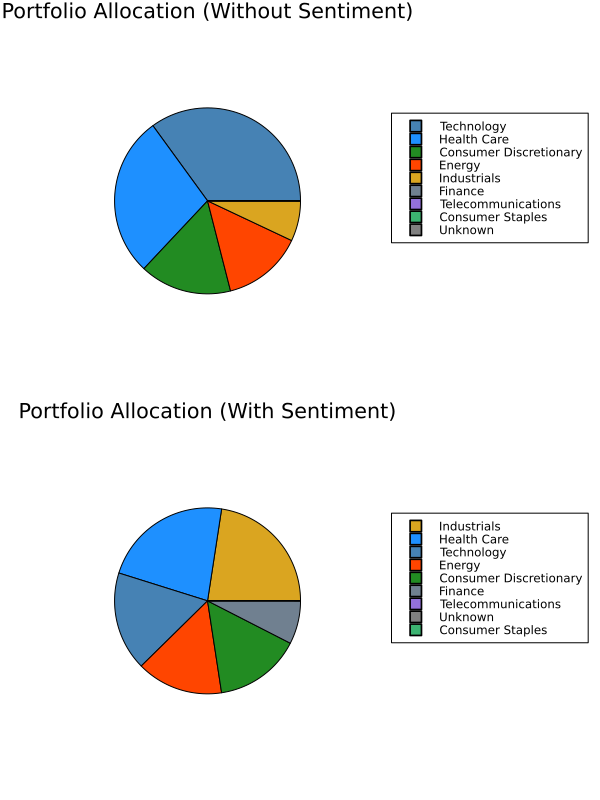

In [11]:
function plot_sector_pie(df::DataFrame, title_str::String, sector_colors::Dict)
    # Group by sector and sum allocations
    sector_allocations = combine(groupby(df, :Sector), :Allocation => sum => :TotalAllocation)
    sort!(sector_allocations, :TotalAllocation, rev = true)

    sectors = sector_allocations.Sector
    allocations = sector_allocations.TotalAllocation
    percentages = round.(allocations ./ sum(allocations) .* 100, digits=1)

    # Create percentage labels for slices
    slice_colors = [sector_colors[s] for s in sectors]

    # Plot pie chart with no default legend and suppress label from appearing in legend
    pie_chart = pie(allocations;
        title = title_str,
        c = slice_colors,
        legend = false,
        label = "")  # <- This line suppresses default label in legend

    # Add legend entries only for present sectors
    for (sector, color) in zip(sectors, slice_colors)
        scatter!(pie_chart, [NaN], [NaN], label = sector, markercolor = color, markershape = :rect)
    end

    plot!(pie_chart, legend = :outertopright)
    return pie_chart
end

# Load the data
df1 = CSV.read("./final_data/top_stocks_no_sentiment.csv", DataFrame)
df2 = CSV.read("./final_data/top_stocks_with_sentiment.csv", DataFrame)

# Define sector colors
sector_colors = Dict(
    "Health Care" => :dodgerblue,
    "Finance" => :slategray,
    "Telecommunications" => :mediumpurple,
    "Consumer Staples" => :mediumseagreen,
    "Energy" => :orangered,
    "Technology" => :steelblue,
    "Consumer Discretionary" => :forestgreen,
    "Industrials" => :goldenrod,
    "Unknown" => :gray
)

# Generate pie charts with legends
p1 = plot_sector_pie(df1, "Portfolio Allocation (Without Sentiment)", sector_colors)
p2 = plot_sector_pie(df2, "Portfolio Allocation (With Sentiment)", sector_colors)

# Show both charts stacked vertically
plot(p1, p2, layout = (2, 1), size=(600, 800))

## 6. Conclusion ##

Our findings of a non-adjusted trading optimizer aligned with typical trading strategy; even going onto our sentiment-adjusted trading optimizer is also relatively aligned with modern trading advice. That being said the rearranging of purchasing allocations from the typical trading strategy to a more "American industrial" investment strategy--in our calculus, favored by the American conservative--rather than an "American technological" investment strategy--in our calculus the favored strategy by the American liberal. We think that this is about as expected as the American right seems to much more concentrated in the places that we are looking in. As a particular case study, we can look at `RTX`, `DE`, and `LMT` as a stock. They are all relatively interesting because none appear within the set of stocks that the non-adjusted, but do appear in the adjusted stocks. If one was to look into this as a market trend, all of these are American heavy manufacturers, two being military contractors and the other being a farming equipment manufacture (Raytheon, John Deere, and Lockeed Martin respectively). If we were to extrapolate this out as a political/societal trend, it would be that there is either excitement in American manufacturing, or simply that the market is going to do so poorly that they look good in comparison.

For a future state of this project, we think that, generally, this project is plagued by perpetually outdated data, and this *likely* would only be solved by making this into a live service model, getting access to enterprise grade API's, and a team with more time to put into this. On the live service model, stock optimization is not helpful unless it is live and traders can view and use data as soon as possible. Our stock data was only able to be gathered over a weekend (market close) so there could be some semblance of consistency whilst using a free API key limited to a specific number of calls per hour. The way that twitter data was collected as well was, suboptimal, and not because of the implementation. Twitter only allows for bulk calls when it is paid an enterprise level sum, meaning that no matter what we did with our college student sum, we could only collect a specific amount of data. A larger dev team could also give a lot of our backend (data collection) a much better UI/UX that can automatically run the data harvesters.

## 6a. Case Study ##

Even though we have made it Abundantly clear our sentiment prediction did seem to pick relatively good stocks, stock data was collected for our algorithms to process 4/25/2025 - 4/27/2025 and the stock pictures below are from 4/30/2025. They show that, at least for our case study of `RTX`, `DE`, and `LMT`, our algorithm picked winners.

<h3 align="center">RTX</p>

<div style="text-align: center;">
    <img src="./images/RTX_perf.png" alt="rtx" width="700"/>
</div>

<h3 align="center">DE</p>

<div style="text-align: center;">
    <img src="./images/DE_perf.png" alt="de" width="700"/>
</div>

<h3 align="center">LMT</p>

<div style="text-align: center;">
    <img src="./images/LMT_perf.png" alt="lmt" width="700"/>
</div>

## 7. Author Contributions

Note: The contributions in each category must sum to 100%. See Canvas for more details on what type of work belongs in each category.

#### 1. Modelling  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  

  
#### 2. Analysis  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 3. Data Gathering  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 4. Software Implementation  
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  


#### 5. Report Writing    
Student A: Percentage contribution %  
Student B: Percentage contribution %  
Student C: Percentage contribution %  